# Gather insights of amazon reviews
## Aim of the analysis (Business understanding)
The analysis wants to answer questions about how the customers interact with the Kindle e-book reader.
Mainly:
- What do they think about the price
    - How do the customers see the different prices of the different models
    - How often do they mention the price
    - Are they content or discontent with the price
- How do customers react to the concept of price reduction for advertising on their Kindles
    - Compare how many of each type (with/without ads) were bought
- How do customers react to the various soft- and hardware features
    - How many customers talk about which soft- and hardware feature?
    - How do the ratings change when they mention a specific feature?

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import re
import warnings
warnings.simplefilter(action='ignore')

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from textblob import TextBlob

%matplotlib notebook

In [2]:
#nltk.download('stopwords')

In [3]:
# Loading the data 
path = 'data/All_reviews.csv'
df = pd.read_csv(path, dtype={"kindle":object})
df.drop(df.columns[0],axis=1, inplace=True)

# Defining colors:
kindle_colors= ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#fcfc05']

## Data Understanding

In [4]:
df.describe()

,stars,comments
count,169090.000000,169090.000000
mean,4.212928,0.232598
std,1.198218,1.186548
min,1.000000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,51.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169090 entries, 0 to 169089
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 169090 non-null  object
 1   ASIN               169090 non-null  object
 2   stars              169090 non-null  int64 
 3   username           169090 non-null  object
 4   title              169089 non-null  object
 5   text               169090 non-null  object
 6   date               169089 non-null  object
 7   offer type         169090 non-null  object
 8   color              156772 non-null  object
 9   verified purchase  169090 non-null  object
 10  comments           169090 non-null  int64 
 11  kindle unlimited   169090 non-null  object
 12  digital storage    169090 non-null  object
 13  connectivity       169090 non-null  object
 14  kindle             169090 non-null  object
dtypes: int64(2), object(13)
memory usage: 19.4+ MB


In [6]:
df["stars"].value_counts()

5    100743
4     34548
3     14394
1     11535
2      7870
Name: stars, dtype: int64

In [7]:
df["kindle unlimited"].value_counts()

Na                           148460
Without Kindle Unlimited      17332
 Without Kindle Unlimited      3298
Name: kindle unlimited, dtype: int64

In [8]:
df["connectivity"].value_counts()

Na                                     124947
Wi-Fi Only                              27456
 Wi-Fi  Only                             9685
AT&T                                     4517
 Wi-Fi + Free Cellular Connectivity      2485
Name: connectivity, dtype: int64

In [9]:
df["color"].value_counts()

Na                122073
Black              15525
Graphite           14724
White               3899
Champagne Gold       551
Name: color, dtype: int64

In [10]:
df.corr()

,stars,comments
stars,1.000000,-0.272035
comments,-0.272035,1.000000


In [11]:
pd.plotting.scatter_matrix(df);

<IPython.core.display.Javascript object>

### Draw histogram of all data for a better vizualization of whats available

In [12]:
#aggregate data
a = df.groupby(["kindle","id","date"], sort=False).count()
#extract one column
data = pd.DataFrame(a["ASIN"])

In [13]:
#Iterate through the kindles and apply the same operations
# extract the data for each kindle to be able to colorcode them
k3 = data.xs(key="3", level="kindle")
k4 = data.xs(key="4", level="kindle")
k5 = data.xs(key="5", level="kindle")
pw5 = data.xs(key="paperwhite 5", level="kindle")
pw6 = data.xs(key="paperwhite 6", level="kindle")
pw7 = data.xs(key="paperwhite 7", level="kindle")
k7 = data.xs(key="7", level="kindle")
v7 = data.xs(key="voyage 7", level="kindle")
k8 = data.xs(key="8", level="kindle")
o9 = data.xs(key="oasis 9", level="kindle")
pw10 = data.xs(key="paperwhite 10", level="kindle")
i=0
kindles = [k3, k4,k5, pw5, pw6, k7, v7, pw7, k8, o9, pw10]


for product in kindles: 
    #Convert the data into the correct format for matplotlib
    product.reset_index(inplace=True)
    product.drop(product.columns[0],axis=1, inplace=True)
    product.set_index('date', inplace=True)
    product.index = pd.to_datetime(product.index).copy()
    product = mpl.dates.date2num(product.index.to_pydatetime()).copy()
    kindles[i] = product
    i+=1

In [14]:
legend = ["Kindle 3", "Kindle 4", "Kindle 5", "Paperwhite 5",
               "Paperwhite 6", "Kindle 7", "Voyage 7", "Paperwhite 7", "Kindle 8", "Oasis 9", "Paperwhite 10"]
fig = plt.figure(figsize=(10,5))
s = fig.add_subplot(111)
#Data needs to be an array to work
s.hist(kindles,bins=120,stacked=True, color=kindle_colors, alpha=1)
s.xaxis.set_major_locator(mdates.YearLocator())
s.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
s.legend(legend);

<IPython.core.display.Javascript object>

## Data Preparation
There are a lot of missing values in the column that record special features like "kindle unlimited" or "connectivity". Interestingly they are strings saying "Na" and not np.nan, which is why they dont show up in the .describe() funciton as null values. Since I will concentrate on the reviews and the ratings (stars), they are the only column that should not have any missing values (which they dont). 

For now all column are kept in the dataframe to be a good basis for the analysis. I will drop some columns or remove rows depending on the analysis I make.

## Analyse how the price affects the ratings

In [17]:
def bi_dict_analysis(df, dictio_filename):
    """
    Dictionary analysis that checks whether words defined in a dictionary are mentioned in a string.
    Expects a dataframe through which rows it will iterate.
    INPUT:
    df - a dataframe with the columns "kindle", "reviews", "title"
    dictio_filename - the file name of an excel file with one column for each topic to be analyzed
    
    OUTPUT:
    -dictio_df a dataframe with one column appended for every topic in the dictionary. The rows are marked if the topic is mentioned.
    -column_names column that were appended
    
    """

    df['kindle'] = df['kindle'].astype(str)
    df.reset_index(inplace=True)
    df.drop(df.columns[0],axis=1,inplace=True)
    
    #Combine title and text 
    df["reviews"] = df["title"].map(str) +" "+ df["text"]

    #Change the reviews type to string
    df['reviews'] = df['reviews'].astype(str)

    #Lowercase all reviews
    df.reviews = df.reviews.apply(lambda x: " ".join(x.lower() for x in x.split()))
    #Remove punctuation
    df.reviews = df.reviews.str.replace('[^\w\s]','')

    #Remove stop words
    stop = stopwords.words('english')
    stop.remove("not")
    stop.remove("with")
    df.reviews = df.reviews.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    # Import the dicionary for the analysis:
    dictio = pd.read_excel('dicts/'+dictio_filename)
    dictio = dictio.applymap(str)
      
    #Creates empty columns for the dictionaries
    column_names = []
    column_names = list(dictio.columns.values)
    df.reviews.dropna()
    #Saves all reviews in the sentences list
    sentences = df.reviews
    df= df.reindex(columns=[*df.columns.tolist(), *column_names], fill_value=np.NaN)
    
    #Analysis starts
    i=0
    #Iterates through the reviews
    total_length = len(sentences)
    #Since the analysis can take very long, some status statements are printed
    print("Process started:")
    s = 1
    prev_status = 100
    #Iteration through every review
    for sentence in sentences:
        #Splits a review text into single words
        words = sentence.split()
        previous_word = ""
        #Iterates through the topics, each is one column in a table
        for column in dictio:
            #Saves the topic words in the pattern list
            pattern = list(dictio[column])
            #Remove empty values
            clean_pattern = [x for x in pattern if str(x) != 'nan']
            match_score = 0
            #Iterates through each entry of the topic list
            for search_words in clean_pattern:
                #Iterates through each word of the review
                for word in words:
                    #When two consecutive words are searched for the first if statement gets activated
                    if len(search_words.split())>1:

                        pattern2 = r"( "+re.escape(search_words.split()[0])+r"([a-z]+|) "+re.escape(search_words.split()[1])+r"([a-z]+|))"
                        #The spaces are important so bedtime doesnt match time
                        if re.search(pattern2, " "+previous_word+" "+word, re.IGNORECASE):
                            #If the word within the review matches the one in the dictionary the score is increased
                            match_score +=1

                    if len(search_words.split())==1:
                        pattern1 = r" "+re.escape(search_words)+r"([a-z]+|)"
                        if re.search(pattern1, " "+word, re.IGNORECASE):
                            match_score +=1

                    #Saves the word for the next iteration to be used as the previous word
                    #This enables to scan for two consecutive words
                    previous_word = word

            result=0 
            #If one word in the review matched one word of the dictionary, it is marked
            if match_score > 0:
                result = 1
            df.at[i, column] = int(result)
        i+=1
        #Prints current status
        factor = round(s/total_length,4)
        if factor%0.05 == 0 and factor != prev_status:
            print("Status: "+str(factor*100)+"%")
            prev_status = factor
        s+=1

    dictio_df = df.copy()
    print("Analysis successfull")
    return (dictio_df, column_names)

In [18]:
(df, column_names) = bi_dict_analysis(df, "price_dict.xlsx")

Process started:
Status: 0.0%
Status: 5.0%
Status: 10.0%
Status: 20.0%
Status: 40.0%
Status: 80.0%
Analysis successfull


In [19]:
#Changing Kindle names for alphabetical sorting
def rename(string):
    if string == "oasis 9":
        string = "9 oasis"
    if string == "paperwhite 10":
        string = "99 paperwhite ten"
    if string == "voyage 7":
        string = "7 voyage"
    if string == "paperwhite 5":
        string = "5 paperwhite"
    if string == "paperwhite 6":
        string = "6 paperwhite"
    if string == "paperwhite 7":
        string = "7 paperwhite"
    return string
wdf = df.copy()
wdf["total"]=1
wdf.kindle = wdf.kindle.apply(rename)
gdf = wdf.groupby("kindle").sum()

In [20]:
#Percentage of review that talk about a topic
gdf.drop(gdf.columns[0:1], axis=1, inplace=True)
gdf["price perc"] = 100*(gdf["price"])/(gdf["total"])
gdf["exp perc"] = 100*(gdf["expensive"])/(gdf["total"])
gdf["cheap perc"] = 100*(gdf["cheap"])/(gdf["total"])

In [21]:
kindle_barplot = kindle_latex = {"3":"Kindle 3","4":"Kindle 4","5":"Kindle 5", "5 paperwhite":"Paperwhite 5", "6 paperwhite":"Paperwhite 6","7": "Kindle 7", "7 paperwhite":"Paperwhite 7", "7 voyage":"Voyage","8":"Kindle 8","9 oasis":"Oasis","99 paperwhite ten":"Paperwhite 10"}

In [22]:
#Reindex with predefined dictionary
gdf.rename(index=kindle_barplot,inplace=True)
#Drop unneccessary columns
gdf.drop(gdf.columns[0:4], axis =1, inplace=True)

In [23]:
bdf = gdf.copy()

<IPython.core.display.Javascript object>


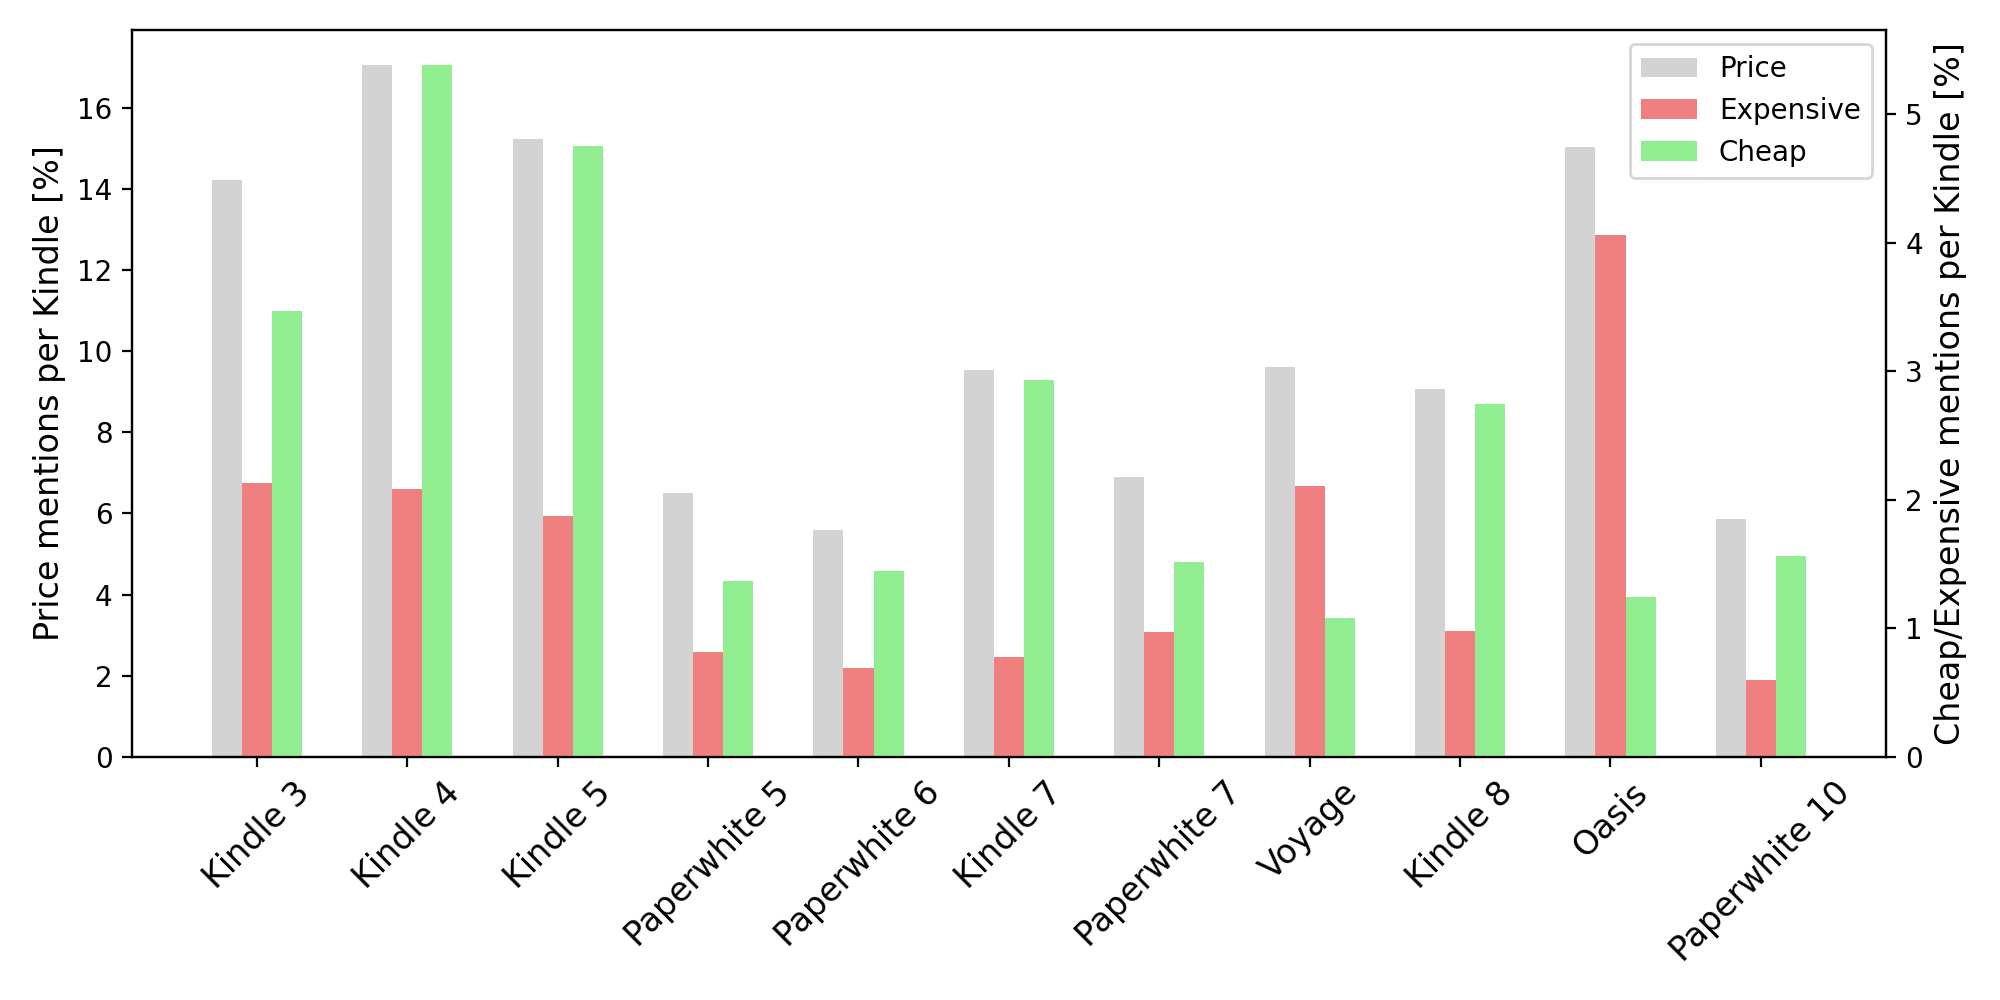

In [48]:
#Draws the graph that compares how often the topics are mentioned for each Kindle
price = list(bdf["price perc"])
exp = list(bdf["exp perc"])
cheap = list(bdf["cheap perc"])

ind = np.arange(len(price))
width = 0.2

fig, ax = plt.subplots(figsize=(10,5))
ax2 = ax.twinx()
rects1 = ax.bar(ind-(width), price, width, label="Price", color="lightgrey")
rects11 = ax.bar(ind, exp, width, label="Expensive", color="lightcoral")
rects111= ax.bar(ind+(width), cheap, width, label="Cheap",color="lightgreen")
rects2 = ax2.bar(ind, exp, width, label="Expensive", color="lightcoral")
rects3 = ax2.bar(ind+(width), cheap, width, label="Cheap",color="lightgreen")

ax.set_ylabel("Price mentions per Kindle [%]", size=12)
ax2.set_ylabel("Cheap/Expensive mentions per Kindle [%]", size=12)
ax.set_xticks(ind)
ax.set_xticklabels(bdf.index.values,rotation=45, size = 12)

ax.legend()
fig.tight_layout()
plt.show()

## Special Offer analysis to see how the advertising trade off influences reviews

In [25]:
sf = df[(df["offer type"].isin((' Without Special Offers $159',
       ' Kindle with Special Offers', ' With Special Offers $139',
       'With Special Offers', 'Without Special Offers',
       ' With Special Offers', ' Without Special Offers')))]

In [26]:
def spec_of(string):
    """
    helper function to look for "with" in a string.
    """
    with_spec = r"(With\s|with\s)"
    if re.search(with_spec , str(string), re.IGNORECASE):
        string = 1
    else:
        string = 0
    return string

In [27]:
sf["offer type"] = sf["offer type"].astype(str)
sf["offer"] = sf["offer type"].apply(spec_of)

In [28]:
#Makes sure the else statement filtered out correctly
zero = sf[sf["offer"]==0]
zero["offer type"].unique()
del sf["offer type"]

In [29]:
def make_senti_analysis(df): 
    #Lowercasing data
    #Change the reviews type to string
    df['text'] = df['text'].astype(str)

    #Lowercase all reviews
    df.text = df.text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    #Remove punctuation
    df.text = df.text.str.replace('[^\w\s]','')
    #Remove stop words
    stop = stopwords.words('english')
    df.text = df.text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    #Stemming
    st = PorterStemmer()
    df.text = df.text.apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

    #Calculate sentiment analysis: 
    def senti(x):
        return TextBlob(x).sentiment  

    df['senti_score'] = df.text.apply(senti)
    df[['sentiment','subjectivity']] = pd.DataFrame(df['senti_score'].tolist(), index=df.index)
    del df['senti_score']
   
    return df

In [30]:
sf = make_senti_analysis(sf)

In [31]:
sf.groupby("offer").describe()

stars                                              comments  \
         count      mean       std  min  25%  50%  75%  max    count   
offer                                                                  
0      25933.0  4.407126  1.083004  1.0  4.0  5.0  5.0  5.0  25933.0   
1      91274.0  4.281537  1.181233  1.0  4.0  5.0  5.0  5.0  91274.0   

                 ... sentiment      subjectivity                           \
           mean  ...       75%  max        count      mean       std  min   
offer            ...                                                        
0      0.220260  ...  0.433333  1.0      25933.0  0.472338  0.221966  0.0   
1      0.193692  ...  0.450000  1.0      91274.0  0.466623  0.233556  0.0   

                                
            25%  50%  75%  max  
offer                           
0      0.371162  0.5  0.6  1.0  
1      0.350000  0.5  0.6  1.0  

[2 rows x 56 columns]

In [32]:
sf.groupby("offer").count()

,id,ASIN,stars,username,title,text,date,color,verified purchase,comments,kindle unlimited,digital storage,connectivity,kindle,reviews,price,expensive,cheap,sentiment,subjectivity
offer,,,,,,,,,,,,,,,,,,,,
0,25933,25933,25933,25933,25933,25933,25933,25933,25933,25933,25933,25933,25933,25933,25933,25933,25933,25933,25933,25933
1,91274,91274,91274,91274,91274,91274,91273,87955,91274,91274,91274,91274,91274,91274,91274,91274,91274,91274,91274,91274


In [33]:
def rename(string):
    if string == "oasis 9":
        string = "9 oasis"
    if string == "paperwhite 10":
        string = "99 paperwhite ten"
    if string == "voyage 7":
        string = "7 voyage"
    if string == "paperwhite 5":
        string = "5 paperwhite"
    if string == "paperwhite 6":
        string = "6 paperwhite"
    return string

sf.kindle = sf.kindle.apply(rename)

In [34]:
gf = sf.groupby(["kindle", "offer"]).count()
gf

id   ASIN  stars  username  title   text   date  \
kindle            offer                                                       
3                 0       8619   8619   8619      8619   8619   8619   8619   
                  1       8769   8769   8769      8769   8769   8769   8769   
4                 0        432    432    432       432    432    432    432   
                  1       5186   5186   5186      5186   5186   5186   5186   
5                 0        778    778    778       778    778    778    778   
                  1       8612   8612   8612      8612   8612   8612   8612   
5 paperwhite      0       2586   2586   2586      2586   2586   2586   2586   
                  1       8847   8847   8847      8847   8847   8847   8847   
6 paperwhite      0       7221   7221   7221      7221   7221   7221   7221   
                  1      24752  24752  24752     24752  24752  24752  24752   
7                 0       1014   1014   1014      1014   1014   1014   1014   
                  1       7591   7591   7591      7591   7591   7591   7591   
7 voyage          0       3445   3445   3445      3445   3445   3445   3445   
                  1       8725   8725   8725      8725   8725   8725   8725   
8                 0        471    471    471       471    471    471    471   
                  1      10706  10706  10706     10706  10706  10706  10706   
9 oasis           0        790    790    790       790    790    790    790   
                  1       2508   2508   2508      2508   2508   2508   2507   
99 paperwhite ten 0        577    577    577       577    577    577    577   
                  1       5578   5578   5578      5578   5578   5578   5578   

                         color  verified purchase  comments  kindle unlimited  \
kindle            offer                                                         
3                 0       8619               8619      8619              8619   
                  1       5450               8769      8769              8769   
4                 0        432                432       432               432   
                  1       5186               5186      5186              5186   
5                 0        778                778       778               778   
                  1       8612               8612      8612              8612   
5 paperwhite      0       2586               2586      2586              2586   
                  1       8847               8847      8847              8847   
6 paperwhite      0       7221               7221      7221              7221   
                  1      24752              24752     24752             24752   
7                 0       1014               1014      1014              1014   
                  1       7591               7591      7591              7591   
7 voyage          0       3445               3445      3445              3445   
                  1       8725               8725      8725              8725   
8                 0        471                471       471               471   
                  1      10706              10706     10706             10706   
9 oasis           0        790                790       790               790   
                  1       2508               2508      2508              2508   
99 paperwhite ten 0        577                577       577               577   
                  1       5578               5578      5578              5578   

                         digital storage  connectivity  reviews  price  \
kindle            offer                                                  
3                 0                 8619          8619     8619   8619   
                  1                 8769          8769     8769   8769   
4                 0                  432           432      432    432   
                  1                 5186          5186     5186   5186   
5                 0                  778           778      77

In [35]:
#calculates the normed values for the stacked bar graph and puts them in seperated lists
x=0
i=0
z=0
o=0
results=[0]*20
zero=[0]*10
one = [0]*10
values = list(gf.id.values)
for i in range(20):
    if i %2 == 0:
        x = values[i]/(values[i]+values[i+1])
        zero[z]=x
        z+=1
    if i %2 == 1:
        x = values[i]/(values[i]+values[i-1])
        one[o]=x
        o+=1
    results[i]=x
    i+=1
    

In [36]:
gf.drop(gf.columns[1:],axis = 1, inplace=True)
gf["percentage"] = results

In [37]:
kindles = ["Kindle 3", "Kindle 4", "Kindle 5", "Paperwhite 5",
           "Paperwhite 6", "Kindle 7", "Voyage", "Kindle 8",
          "Oasis", "Paperwhite 10"]

<IPython.core.display.Javascript object>


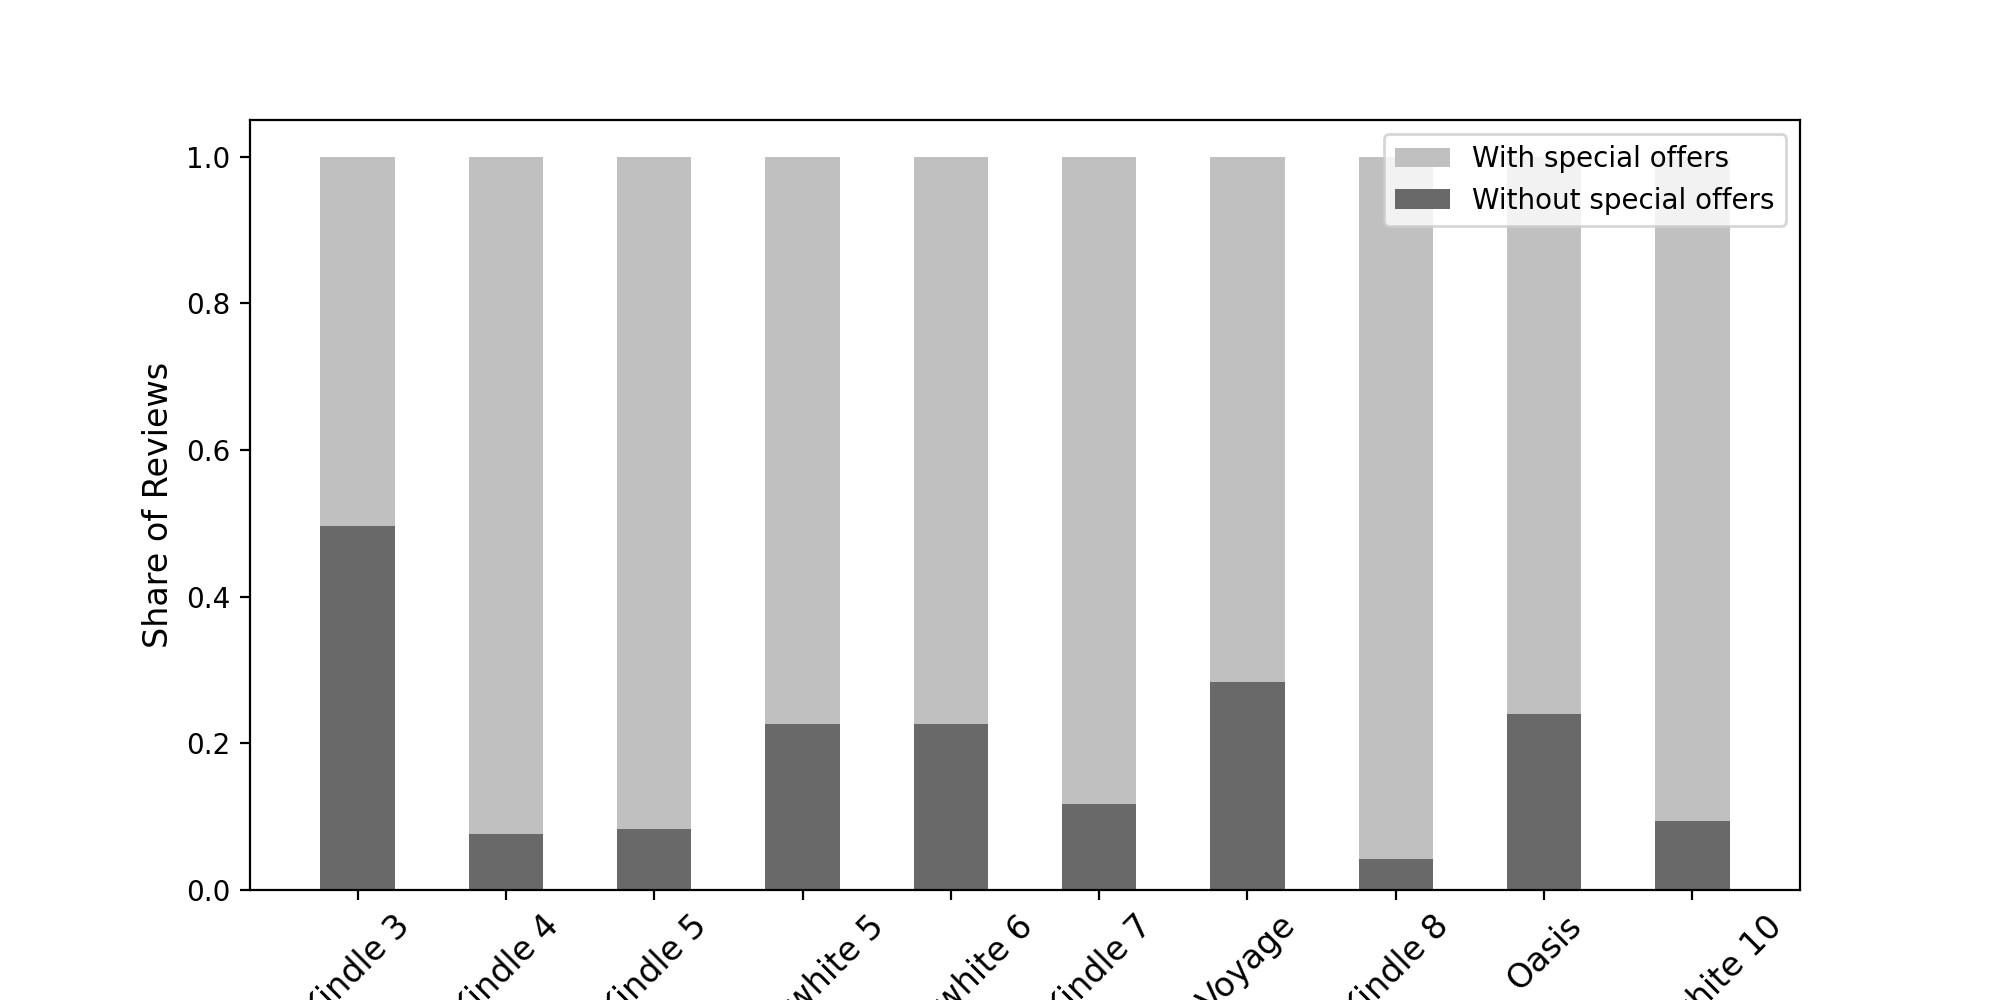

In [47]:
N = 10
without_off = zero
with_off = one
plt.figure(figsize=(10,5))
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, without_off, width, color="dimgrey")
p2 = plt.bar(ind, with_off, width, bottom=without_off,color="silver")

plt.ylabel('Share of Reviews',size=12)

plt.xticks(ind, kindles)
plt.legend((p2[0], p1[0]), ('With special offers', 'Without special offers'))
plt.xticks(rotation=45, size = 12)
plt.yticks(size = 10)


plt.show()

## Analysis how customers react on software features


In [39]:
#Run the dictionary analysis
(da_soft, column_names) = bi_dict_analysis(df,"Software_features_dict.xlsx")

Process started:
Status: 0.0%
Status: 5.0%
Status: 10.0%
Status: 20.0%
Status: 40.0%
Status: 80.0%
Analysis successfull


In [40]:
#Count how often each dictionary got mentioned
rdf_soft= da_soft.copy()
grdf_soft= rdf_soft.groupby(["kindle"]).sum()
count_soft = rdf_soft.groupby(["kindle"]).count()
count_soft.drop(count_soft.columns[1:],axis=1,inplace=True)
grdf_soft.drop(grdf_soft.columns[0:3],axis=1,inplace=True)
results_soft = grdf_soft

In [41]:
# Tables are created with LaTex
latex_soft = grdf_soft.T
#Moving the paperwhite 7 column to the front for proper order
latex_soft = latex_soft[ ['paperwhite 7'] + [ col for col in latex_soft.columns if col != 'paperwhite 7' ] ]
latex_soft = latex_soft.astype(int)
#Print results in a latex formatted way
print (latex_soft.to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
kindle &  paperwhite 7 &     3 &    4 &    5 &    7 &    8 &  oasis 9 &  paperwhite 10 &  paperwhite 5 &  paperwhite 6 &  voyage 7 \\
\midrule
expensive          &           199 &   658 &  168 &  220 &  101 &  109 &      134 &             37 &           153 &           231 &       256 \\
cheap              &           310 &  1069 &  435 &  557 &  379 &  307 &       41 &             96 &           256 &           485 &       131 \\
Audible            &           110 &   205 &   19 &   15 &   40 &  176 &      218 &            260 &            83 &           126 &        52 \\
Special offers     &           236 &   854 &  318 &  264 &  153 &   96 &       32 &             71 &           275 &           375 &       153 \\
Page Flip          &            75 &    97 &   21 &   20 &   36 &   19 &       27 &             13 &            48 &            98 &        43 \\
Export notes       &             5 &     1 &    0 &    0 &    0 &    1 &        0 &     

In [42]:
#Calculates how many times the topics were mentioned across the kindles
df_soft = rdf_soft
grdf_soft= rdf_soft.groupby(["kindle"]).sum()
count_soft = rdf_soft.groupby(["kindle"]).count()
count_soft.drop(count_soft.columns[1:],axis=1,inplace=True)
grdf_soft.drop(grdf_soft.columns[0:3],axis=1,inplace=True)
print(grdf_soft.sum())

expensive             2266.0
cheap                 4066.0
Audible               1304.0
Special offers        2827.0
Page Flip              497.0
Export notes             8.0
X-ray                  294.0
Word wise               55.0
Dictionary             141.0
Vocabulary Builder     334.0
Whispersync            205.0
Adjustable text       5714.0
Family library          14.0
Goodreads              398.0
Time to read          1323.0
Footnotes              122.0
Translation            115.0
Lend books             549.0
dtype: float64


### Ratings dependend on discussed topic

In [43]:
#Calculates the mean rating whether the topic was discussed about or not
results_soft = pd.DataFrame()
for column in column_names:
    zdf_soft = rdf_soft.groupby([column]).mean()
    zdf_soft.drop(zdf_soft.columns[1:], axis = 1, inplace = True)
    results_soft[column] = zdf_soft.stars

In [44]:
grdf_soft.sum()

expensive             2266.0
cheap                 4066.0
Audible               1304.0
Special offers        2827.0
Page Flip              497.0
Export notes             8.0
X-ray                  294.0
Word wise               55.0
Dictionary             141.0
Vocabulary Builder     334.0
Whispersync            205.0
Adjustable text       5714.0
Family library          14.0
Goodreads              398.0
Time to read          1323.0
Footnotes              122.0
Translation            115.0
Lend books             549.0
dtype: float64

In [46]:
#Generates the table for the latex document
table_soft = results_soft.T
table_soft["Num. of reviews"] = list(grdf_soft.sum())
table_soft["Num. of reviews"] = table_soft["Num. of reviews"].astype(int)
table_soft["change"] = round(table_soft[1.0]-table_soft[0.0],2)
table_soft[1.0] = round(table_soft[1.0],2)
table_soft[0.0] = round(table_soft[0.0],2)
table_soft = table_soft[["Num. of reviews", 1.0, 0.0, "change"]]

def redgreen(num):
    if num<0:
        return "\textcolor{DarkRed}{"+str(num)+"}"
    if num>0:
        return "\textcolor{Green}{"+str(num)+"}"
    else:
        return str(num)

table_soft.change = table_soft.change.apply(lambda x: redgreen(x))
print(table_soft.to_latex(escape=False))

ValueError: Length of values (18) does not match length of index (16)

In [ ]:
#Average rating across all reviews
print(rdf_soft.stars.mean())

## Analysis how customers react on software features¶

In [ ]:
(da_hard, column_names) = bi_dict_analysis(df,"Hardware_features_dict.xlsx")

In [ ]:
rdf_hard= da_hard.copy()
grdf_hard= rdf_hard.groupby(["kindle"]).sum()
count_hard = rdf_hard.groupby(["kindle"]).count()
count_hard.drop(count_hard.columns[1:],axis=1,inplace=True)
grdf_hard.drop(grdf_hard.columns[0:3],axis=1,inplace=True)
results_hard = grdf_hard

In [ ]:
latex_hard = grdf_hard.T

#moving the paperwhite 7 column to the front for proper order
latex_hard = latex_hard[ ['paperwhite 7'] + [ col for col in latex_hard.columns if col != 'paperwhite 7' ] ]
latex_hard = latex_hard.astype(int)

print (latex_hard.to_latex())

In [ ]:
#calculates the mean rating whether the topic was discussed about or not
results_hard = pd.DataFrame()
for column in column_names:
    zdf_hard = rdf_hard.groupby([column]).mean()
    zdf_hard.drop(zdf_hard.columns[1:], axis = 1, inplace = True)
    results_hard[column] = zdf_hard.stars

#results  

In [ ]:
#calculates how many times the topics were mentioned across the kindles
df_hard = rdf_hard
grdf_hard= rdf_hard.groupby(["kindle"]).sum()
count_hard = rdf_hard.groupby(["kindle"]).count()
count_hard.drop(count_hard.columns[1:],axis=1,inplace=True)
grdf_hard.drop(grdf_hard.columns[0:3],axis=1,inplace=True)

#grdf.sum()

### Ratings dependend on discussed topic

In [ ]:
#generates the table for the latex document
table_hard = results_hard.T
table_hard["Num. of reviews"] = list(grdf_hard.sum())
table_hard["Num. of reviews"] = table_hard["Num. of reviews"].astype(int)
table_hard["change"] = round(table_hard[1.0]-table[0.0],2)
table_hard[1.0] = round(table_hard[1.0],2)
table_hard[0.0] = round(table_hard[0.0],2)
table_hard = table_hard[["Num. of reviews", 1.0, 0.0, "change"]]

def redgreen(num):
    if num<0:
        return "\textcolor{DarkRed}{"+str(num)+"}"
    if num>0:
        return "\textcolor{Green}{"+str(num)+"}"
    else:
        return str(num)

table_hard.change = table_hard.change.apply(lambda x: redgreen(x))
print(table_hard.to_latex(escape=False))